# Skin Lesion Detection Project - Adrian Pal

Skin lesions are a crucial aspect of dermatological health, and early detection plays a pivotal role in successful treatment. In this project, I focus on leveraging neural networks to aid in the early detection of skin lesions, addressing the importance of timely identification.

## Neural Networks Utilized

1. **Custom Neural Network:** A tailored neural network designed specifically for skin lesion detection.
2. **VGG16 and ResNet50:** Comparison with popular pre-trained models for benchmarking.

## Lesion Types

My analysis involves distinguishing various skin lesion types, categorized as follows:

- **Melanocytic nevi (nv)**
- **Melanoma (mel)**
- **Benign keratosis-like lesions (bkl)**
- **Basal cell carcinoma (bcc)**
- **Actinic keratoses (akiec)**
- **Vascular lesions (vasc)**
- **Dermatofibroma (df)**

## Dataset Used

I utilize the HAM10000 dataset, which comprises a diverse collection of skin lesion images. The dataset includes annotations and labels for different lesion types, providing valuable ground truth for training and evaluation. Additionally, I incorporate data from the ISIC (International Skin Imaging Collaboration) for comprehensive analysis.

## Objective

My primary goal is to classify skin lesions into benign and harmful categories, facilitating early identification of potentially malignant lesions. The custom neural network is tailored to address specific challenges in dermatological image analysis.

## Comparison Metrics

I evaluate the performance of my custom model against pre-trained VGG16 and ResNet50 architectures. Comparison metrics include accuracy, precision, recall, and F1-score, providing insights into the effectiveness of each model.

**Note:** The provided `lesion_type_dict` maps lesion type codes to their corresponding names, aiding in result interpretation.

Import needed libraries!

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)

from sklearn.metrics import confusion_matrix
import itertools

import keras
import shutil
from keras import regularizers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import keras
from keras import regularizers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

from google.colab import drive
from zipfile import ZipFile

from sklearn.metrics import confusion_matrix
import itertools

Mount Google Drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set the base directory and image directories
base_skin_dir = '/content/drive/MyDrive/Skin Lesions Classifications - Dissertation'
base_skin_metadata = os.path.join(base_skin_dir, 'HAM10000_metadata.csv')
image_zip_files = [
    '/content/drive/MyDrive/Skin Lesions Classifications - Dissertation/HAM10000_images_part_1.zip',
    '/content/drive/MyDrive/Skin Lesions Classifications - Dissertation/HAM10000_images_part_2.zip'
]

destination_dir = '/content/Skin_Lesions'  # Changed destination_dir name to avoid spaces

# Create destination directory if it doesn't exist
os.makedirs(destination_dir, exist_ok=True)

# Copy metadata CSV to the destination folder
shutil.copy(base_skin_metadata, destination_dir)

# Create a subfolder to store the extracted images
image_folder = os.path.join(destination_dir, 'HAM10000_images')

# Create image folder if it doesn't exist
os.makedirs(image_folder, exist_ok=True)

# Unzip image files and move them to the destination folder
for zip_file in image_zip_files:
    with ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(image_folder)

# List the extracted files
extracted_files = os.listdir(image_folder)
print("Extracted files:", extracted_files)

# Update base_skin_dir to point to the folder containing all images
base_skin_dir = image_folder


Extracted files: ['ISIC_0029051.jpg', 'ISIC_0029649.jpg', 'ISIC_0030192.jpg', 'ISIC_0026145.jpg', 'ISIC_0033808.jpg', 'ISIC_0027202.jpg', 'ISIC_0026075.jpg', 'ISIC_0029298.jpg', 'ISIC_0026296.jpg', 'ISIC_0033647.jpg', 'ISIC_0029306.jpg', 'ISIC_0025904.jpg', 'ISIC_0030317.jpg', 'ISIC_0033399.jpg', 'ISIC_0026271.jpg', 'ISIC_0032064.jpg', 'ISIC_0025643.jpg', 'ISIC_0032395.jpg', 'ISIC_0031380.jpg', 'ISIC_0030740.jpg', 'ISIC_0026436.jpg', 'ISIC_0027722.jpg', 'ISIC_0033058.jpg', 'ISIC_0034146.jpg', 'ISIC_0029158.jpg', 'ISIC_0032178.jpg', 'ISIC_0026573.jpg', 'ISIC_0033398.jpg', 'ISIC_0031245.jpg', 'ISIC_0030931.jpg', 'ISIC_0030595.jpg', 'ISIC_0031224.jpg', 'ISIC_0028781.jpg', 'ISIC_0025819.jpg', 'ISIC_0032458.jpg', 'ISIC_0025014.jpg', 'ISIC_0027452.jpg', 'ISIC_0032501.jpg', 'ISIC_0026001.jpg', 'ISIC_0024601.jpg', 'ISIC_0025072.jpg', 'ISIC_0031151.jpg', 'ISIC_0032888.jpg', 'ISIC_0025334.jpg', 'ISIC_0025968.jpg', 'ISIC_0031230.jpg', 'ISIC_0026042.jpg', 'ISIC_0031927.jpg', 'ISIC_0032608.jpg', 'I

Image pre-processing

In [ ]:
# Merge images from the folder into a dictionary with image IDs as keys and file paths as values
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*.jpg'))}

# This dictionary is useful for displaying more friendly - easier labels

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

Read the skin lesions csv

In [ ]:
tile_df = pd.read_csv("./Skin_Lesions/HAM10000_metadata.csv")

tile_df.tail()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,vidir_modern
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,vidir_modern
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,vidir_modern
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,vidir_modern
10014,HAM_0003521,ISIC_0032258,mel,histo,70.0,female,back,vidir_modern


Link text images to the images ids from each row and add an extra column.


In [ ]:
# Create a new column in the DataFrame (path to image) and review the DataFrame


tile_df['path'] = tile_df['image_id'].map(imageid_path_dict.get)
tile_df['cell_type'] = tile_df['dx'].map(lesion_type_dict.get)
tile_df['cell_type_idx'] = pd.Categorical(tile_df['cell_type']).codes

tile_df.tail()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,path,cell_type,cell_type_idx
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,vidir_modern,/content/Skin_Lesions/HAM10000_images/ISIC_003...,Actinic keratoses,0
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,vidir_modern,/content/Skin_Lesions/HAM10000_images/ISIC_003...,Actinic keratoses,0
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,vidir_modern,/content/Skin_Lesions/HAM10000_images/ISIC_003...,Actinic keratoses,0
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,vidir_modern,/content/Skin_Lesions/HAM10000_images/ISIC_003...,Actinic keratoses,0
10014,HAM_0003521,ISIC_0032258,mel,histo,70.0,female,back,vidir_modern,/content/Skin_Lesions/HAM10000_images/ISIC_003...,Melanoma,5


Add Benign && Non-Benign tags to each

In [ ]:
# Create a list of benign lesion types
benign_types = ['Actinic keratoses', 'Benign keratosis-like lesions', 'Melanocytic nevi', 'Dermatofibroma']

# Create 'benign_status' column
tile_df['benign_status'] = tile_df['cell_type'].apply(lambda x: 'Benign' if x not in benign_types else 'Non-Benign')

# Display the updated DataFrame
tile_df.tail()


,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,path,cell_type,cell_type_idx,benign_status
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,vidir_modern,/content/Skin_Lesions/HAM10000_images/ISIC_003...,Actinic keratoses,0,Non-Benign
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,vidir_modern,/content/Skin_Lesions/HAM10000_images/ISIC_003...,Actinic keratoses,0,Non-Benign
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,vidir_modern,/content/Skin_Lesions/HAM10000_images/ISIC_003...,Actinic keratoses,0,Non-Benign
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,vidir_modern,/content/Skin_Lesions/HAM10000_images/ISIC_003...,Actinic keratoses,0,Non-Benign
10014,HAM_0003521,ISIC_0032258,mel,histo,70.0,female,back,vidir_modern,/content/Skin_Lesions/HAM10000_images/ISIC_003...,Melanoma,5,Benign


In [ ]:
# Print the total number of rows and columns
print("Total rows and columns before removing 'None' values:", tile_df.shape)

# Remove rows with 'None' in the 'path' column
tile_df = tile_df[tile_df['path'].notna()]

# Print the total number of rows and columns after removing 'None' values
print("Total rows and columns after removing 'None' values:", tile_df.shape)


Total rows and columns before removing 'None' values: (10015, 12)
Total rows and columns after removing 'None' values: (10015, 12)


The distribution of different cell types

<Axes: >

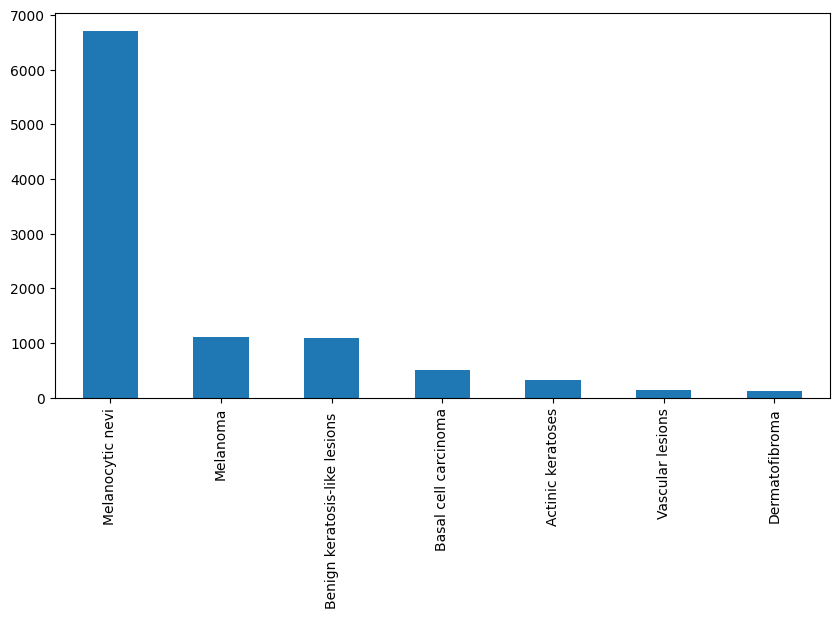

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
tile_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

Too many melanocytic nevi - let's balance it a bit!

<Axes: >

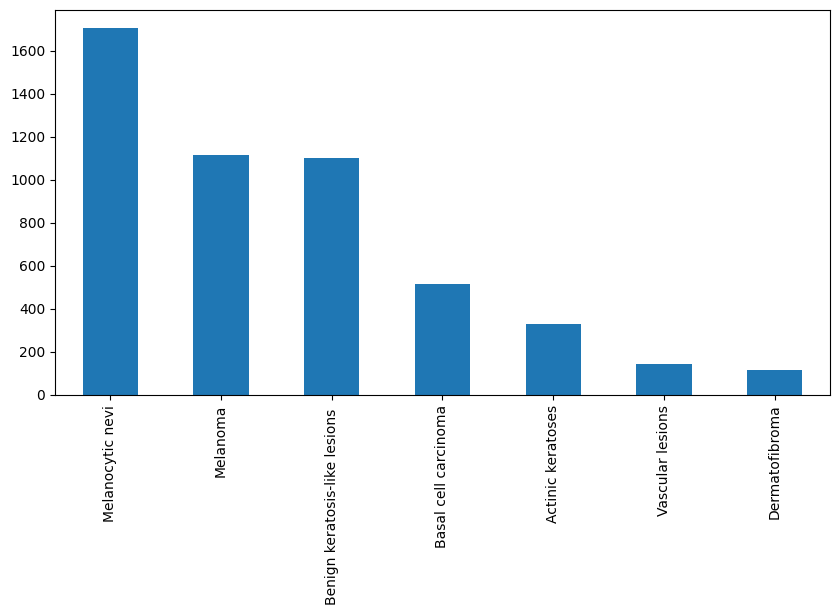

In [ ]:
tile_df = tile_df.drop(tile_df[tile_df.cell_type_idx == 4].iloc[:5000].index)

fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
tile_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

In [ ]:
input_dims = (32, 32)
input_shape = input_dims + (3,)

# Load in all of the images into memory - this will take a while.
# I also do a resize step because the original dimensions of 450 * 600 * 3 was too much for TensorFlow

tile_df['image'] = tile_df['path'].map(lambda x: np.asarray(Image.open(x).resize(input_dims)))

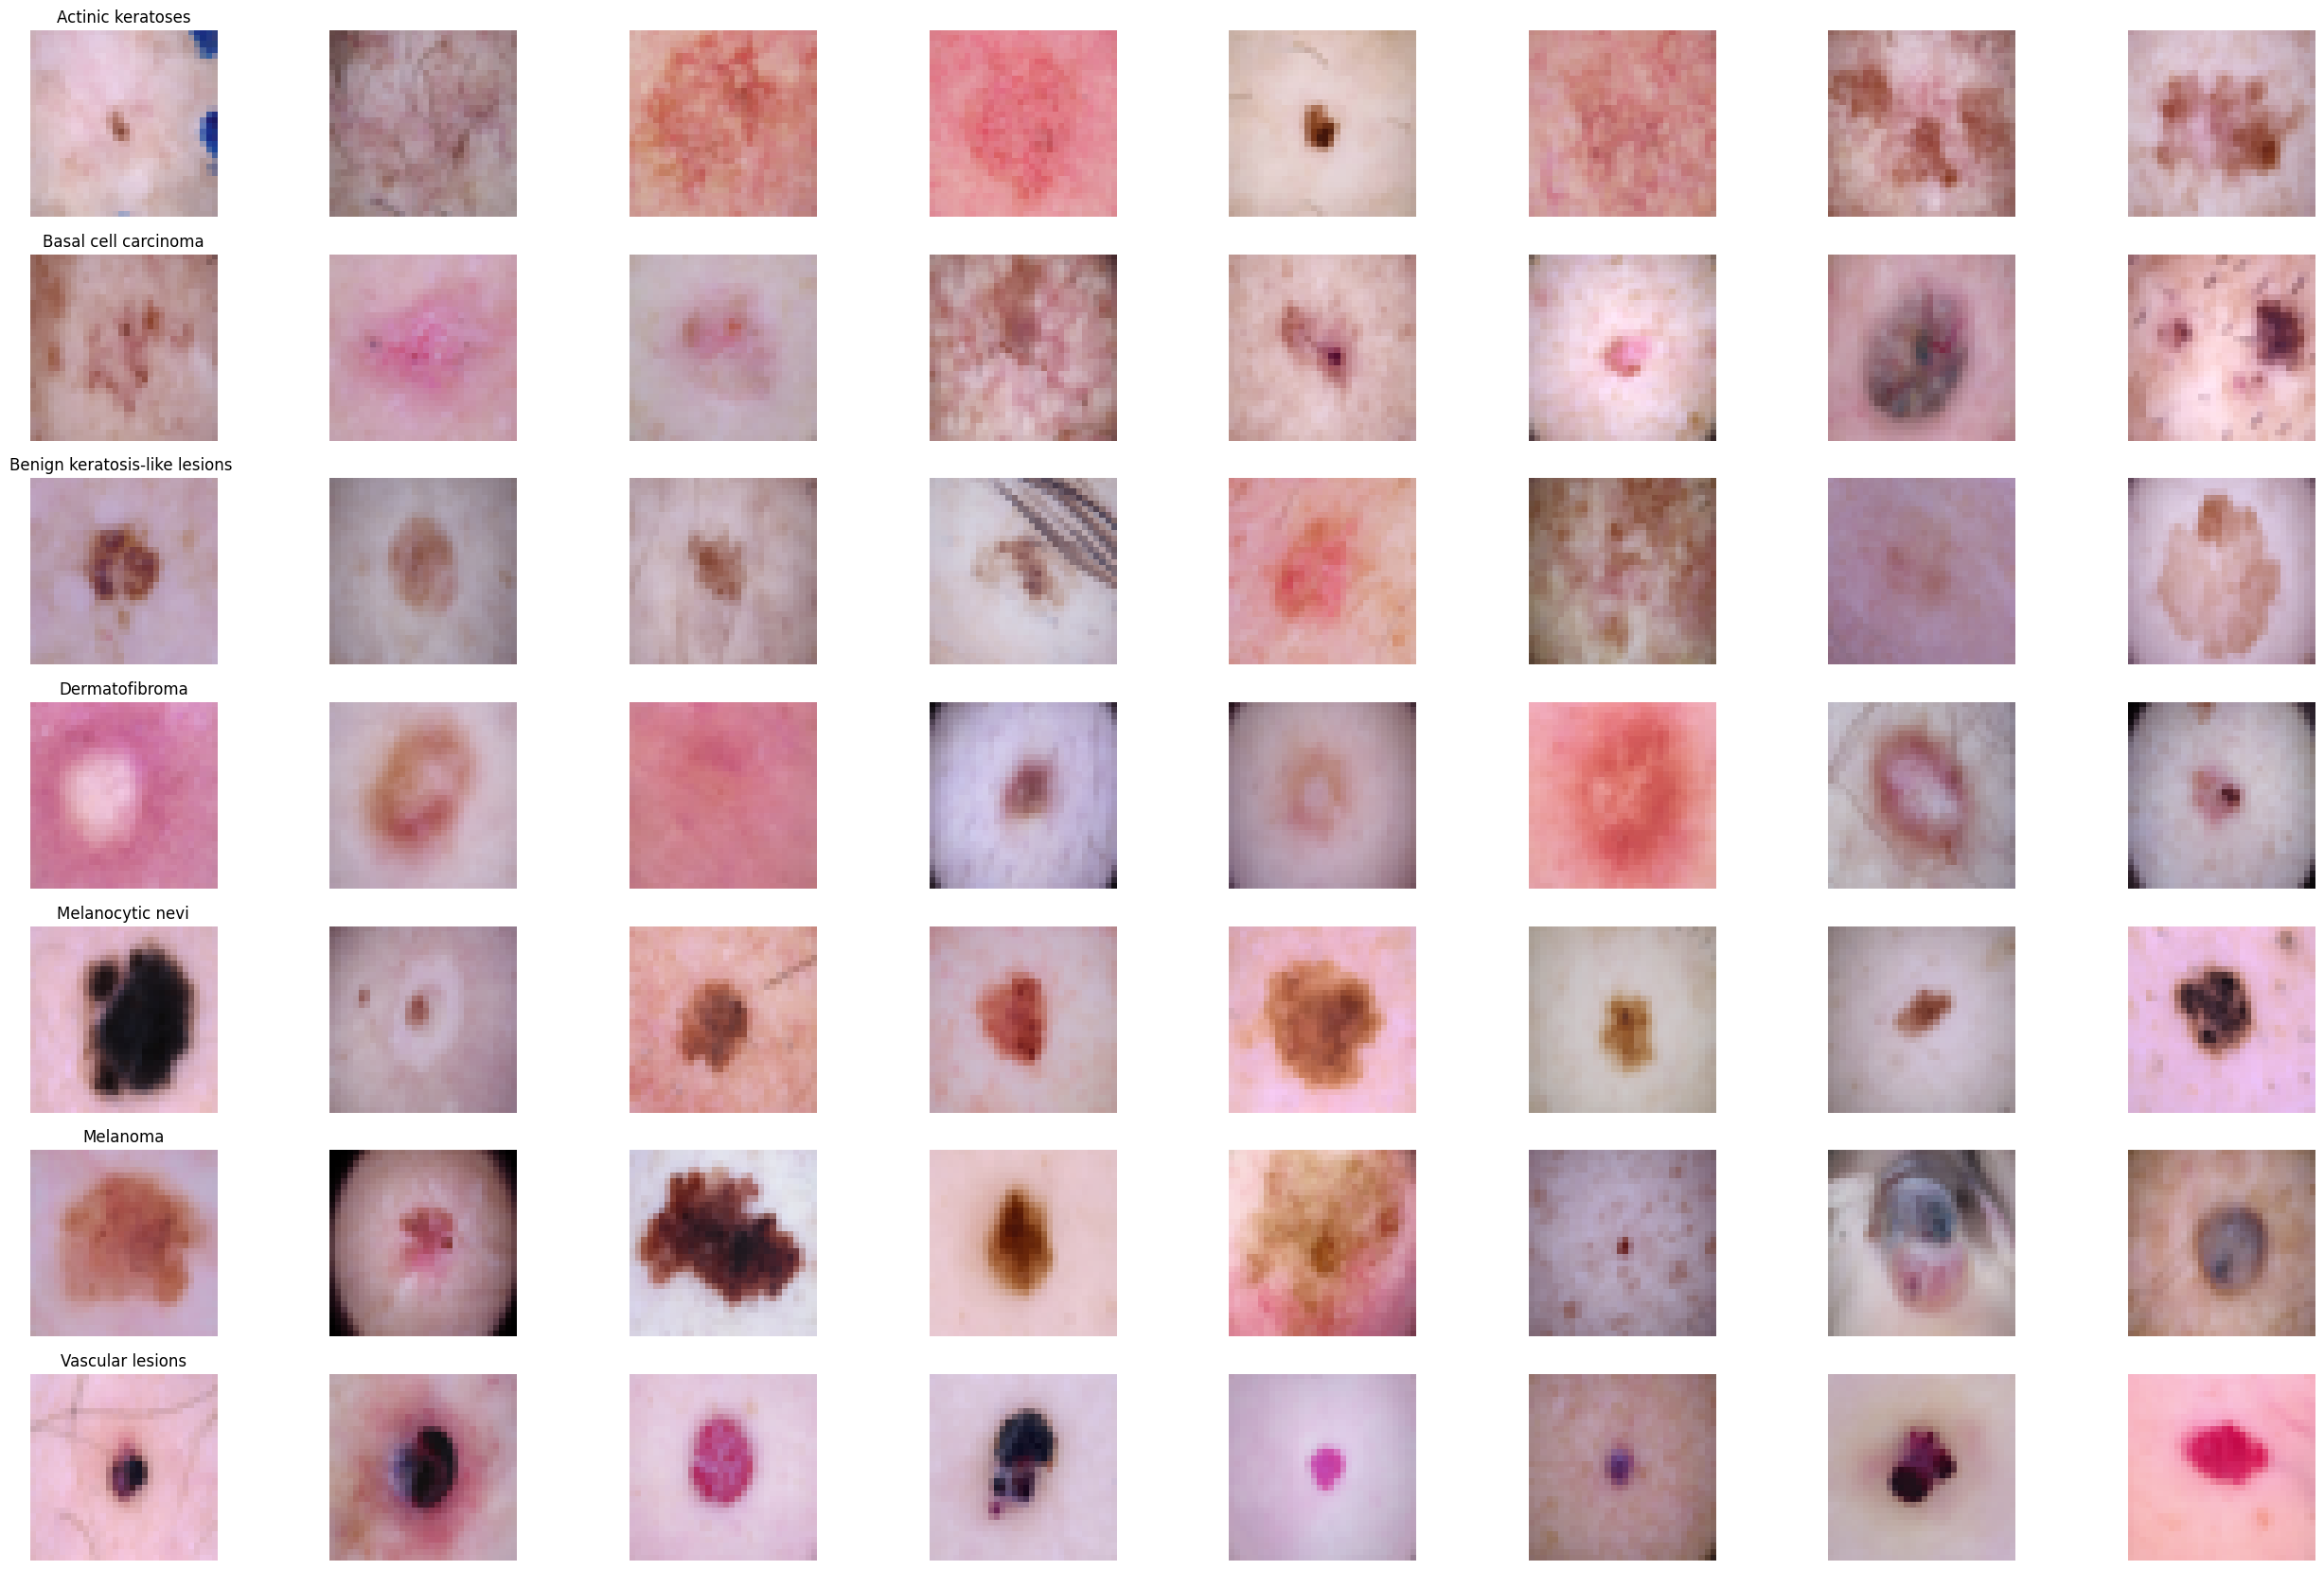

In [ ]:
# Find the unique types of skin lesions
unique_types = tile_df['cell_type'].unique()

# Get the number of unique types
num_unique_types = len(unique_types)

# Define the number of columns (samples per row)
n_samples = 8

# Create the subplot grid with the appropriate number of rows and columns
fig, m_axs = plt.subplots(num_unique_types, n_samples, figsize=(4 * n_samples, 3 * num_unique_types))

# Loop through the unique types and plot samples for each type
for n_axs, (type_name, type_rows) in zip(m_axs, tile_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=2018).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

# Remove any empty subplots if there are fewer unique types than the number of rows
if num_unique_types < len(m_axs):
    for ax in m_axs.flat[num_unique_types * n_samples:]:
        ax.axis('off')

# Save the figure
fig.savefig('category_samples.png', dpi=300)

Export to csv

In [ ]:
tile_df.to_csv('processed_data.csv')

y = tile_df.cell_type_idx
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(tile_df, y, test_size=0.25)

Training the model

In [ ]:

# Preprocessing
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean) / x_train_std
x_test = (x_test - x_test_mean) / x_test_std

y_train = to_categorical(y_train_o, num_classes=7)
y_test = to_categorical(y_test_o, num_classes=7)

# Model configuration
input_shape = (32, 32, 3)
num_classes = 7

# Define the model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
initial_learning_rate = 0.001
opt = keras.optimizers.Adam(learning_rate=initial_learning_rate)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=opt,
              metrics=['accuracy'])

# Print the model summary
model.summary()

# Data augmentation
data_augmentation = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 128)       147584    
                                                        

Fitting the model

In [ ]:
# Train the model with data augmentation
epochs = 100
batch_size = 128

history = model.fit(data_augmentation.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(x_train) // batch_size,
                    epochs=epochs,
                    validation_data=(x_test, y_test))

Epoch 1/100
29/29 [==============================] - 14s 98ms/step - loss: 4.1166 - accuracy: 0.3438 - val_loss: 2.4445 - val_accuracy: 0.4282
Epoch 2/100
29/29 [==============================] - 2s 86ms/step - loss: 2.0110 - accuracy: 0.4008 - val_loss: 1.6788 - val_accuracy: 0.4250
Epoch 3/100
29/29 [==============================] - 2s 77ms/step - loss: 1.6259 - accuracy: 0.4170 - val_loss: 1.5276 - val_accuracy: 0.4609
Epoch 4/100
29/29 [==============================] - 3s 90ms/step - loss: 1.4913 - accuracy: 0.4272 - val_loss: 1.4381 - val_accuracy: 0.4514
Epoch 5/100
29/29 [==============================] - 3s 112ms/step - loss: 1.4379 - accuracy: 0.4495 - val_loss: 1.4185 - val_accuracy: 0.4498
Epoch 6/100
29/29 [==============================] - 2s 78ms/step - loss: 1.4064 - accuracy: 0.4671 - val_loss: 1.3345 - val_accuracy: 0.4936
Epoch 7/100
29/29 [==============================] - 2s 78ms/step - loss: 1.3768 - accuracy: 0.4759 - val_loss: 1.3763 - val_accuracy: 0.5080
Epoc

Graphs for accuracy and loss during training and validation

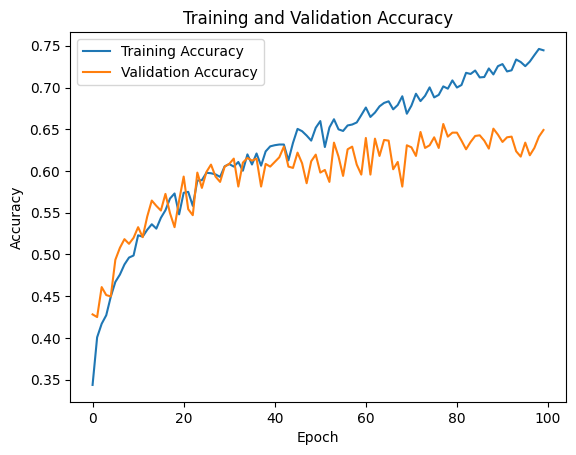

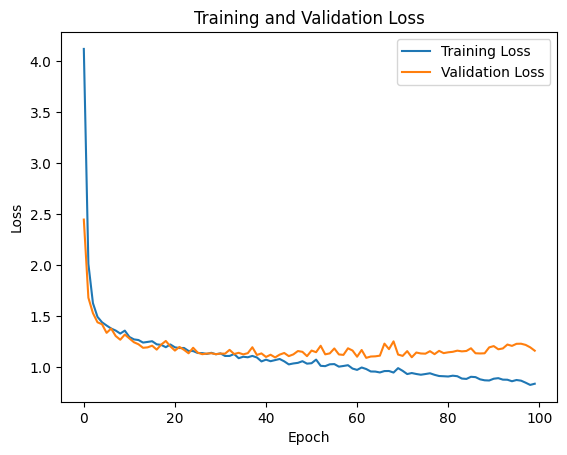

In [ ]:
# Train and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Train and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Evaluate the model on the test dataset and plot the accuracy and loss for the test dataset

In [ ]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

# Plot the accuracy and loss for the test dataset
predictions = model.predict(x_test)
test_labels = np.argmax(y_test, axis=1)
test_predictions = np.argmax(predictions, axis=1)

# Test accuracy
correct = np.sum(test_labels == test_predictions)
total = len(test_labels)
test_accuracy = correct / total
print(f'Test Accuracy: {test_accuracy:.4f}')

# Test loss
test_loss = keras.losses.categorical_crossentropy(y_test, predictions).numpy().mean()
print(f'Test Loss: {test_loss:.4f}')

# Mapping class indices to lesion type names
lesion_type_dict = {
    0: 'Melanocytic nevi',
    1: 'Melanoma',
    2: 'Benign keratosis-like lesions',
    3: 'Basal cell carcinoma',
    4: 'Actinic keratoses',
    5: 'Vascular lesions',
    6: 'Dermatofibroma'
}

# Display the predictions and ground truth for a few examples
num_examples = 10
for i in range(num_examples):
    predicted_label = lesion_type_dict[test_predictions[i]]
    correct_label = lesion_type_dict[test_labels[i]]
    print(f"Example {i + 1}: Predicted: {predicted_label}, Correct: {correct_label}")


Test Loss: 1.1598, Test Accuracy: 0.6491
40/40 [==============================] - 1s 8ms/step
Test Accuracy: 0.6491
Test Loss: 0.9818
Example 1: Predicted: Vascular lesions, Correct: Vascular lesions
Example 2: Predicted: Melanoma, Correct: Melanocytic nevi
Example 3: Predicted: Melanoma, Correct: Benign keratosis-like lesions
Example 4: Predicted: Actinic keratoses, Correct: Actinic keratoses
Example 5: Predicted: Benign keratosis-like lesions, Correct: Vascular lesions
Example 6: Predicted: Actinic keratoses, Correct: Actinic keratoses
Example 7: Predicted: Actinic keratoses, Correct: Actinic keratoses
Example 8: Predicted: Actinic keratoses, Correct: Actinic keratoses
Example 9: Predicted: Melanoma, Correct: Melanoma
Example 10: Predicted: Actinic keratoses, Correct: Actinic keratoses


Save the model in SavedModel format


In [ ]:
# The SavedModel will be saved in a directory named 'skin_lesion_model'
model.save('skin_lesion_model')

# Convert the SavedModel to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_saved_model('skin_lesion_model')
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a specific directory in Colab runtime
output_path = '/content/skin_lesion_model.tflite'
with open(output_path, 'wb') as f:
    f.write(tflite_model)


Method to Plot the history of the model

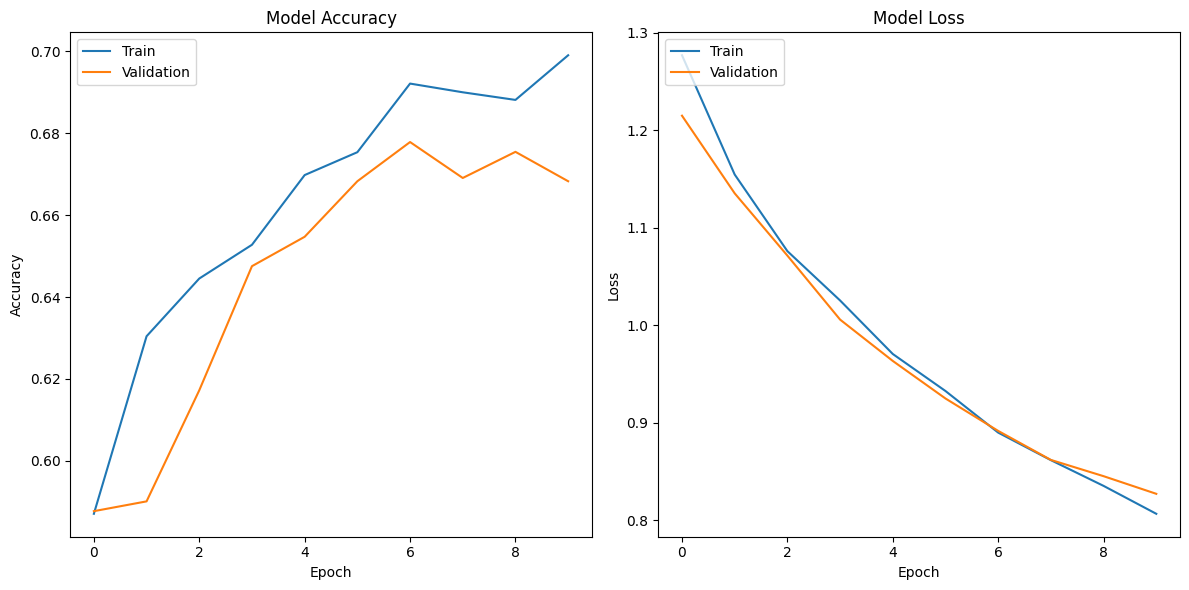

In [ ]:
# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 6))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_history(history_binary)


Model for Benign and Non-Benign skin lesions

1    2868
0    2147
Name: benign_type, dtype: int64
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 30, 30, 16)        448       
                                                                 
 batch_normalization_3 (Bat  (None, 30, 30, 16)        64        
 chNormalization)                                                
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 15, 15, 16)        0         
 g2D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 15, 15, 16)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 13, 13, 32)        4640      
                                                                 
 f

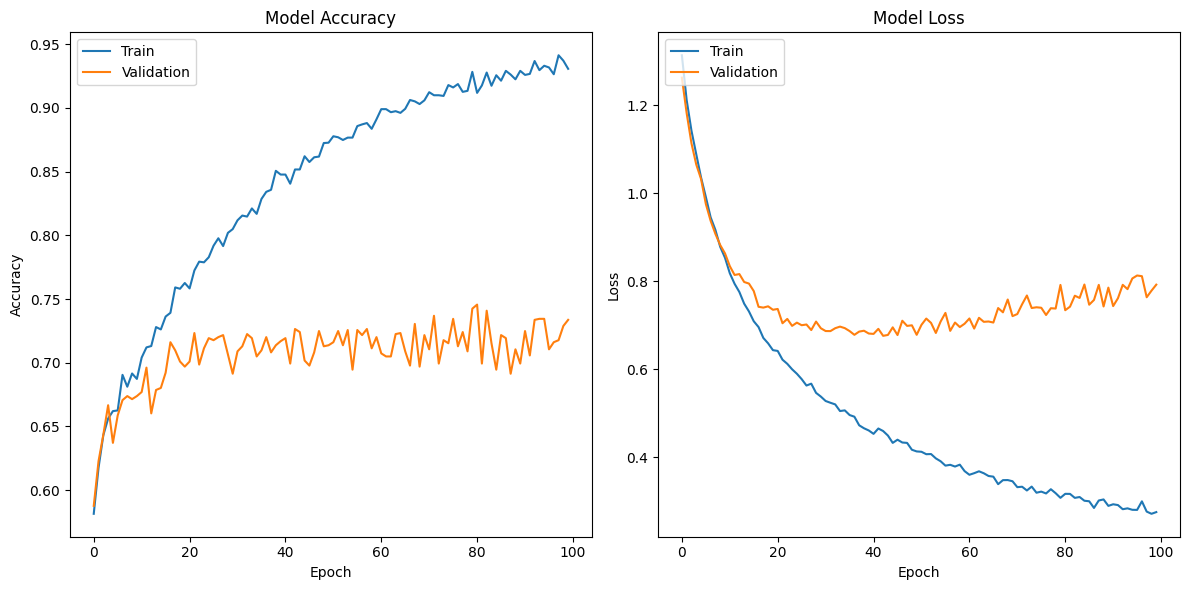

In [ ]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
import numpy as np
from PIL import Image
from keras.layers import BatchNormalization


# 'benign_status' is the feature to predict (Bening-> 1 and Non-Bening->0)
tile_df['benign_type'] = tile_df['benign_status'].apply(lambda x: 1 if x == 'Benign' else 0)

# Count the number of samples for each class in the updated dataset
class_counts_updated = tile_df['benign_type'].value_counts()

# Display the counts
print(class_counts_updated)

# Load in all of the images into memory
tile_df['image'] = tile_df['path'].map(lambda x: np.asarray(Image.open(x).resize(input_dims)))

# Preprocessing
x_data = np.asarray(tile_df['image'].tolist())
y_data = np.asarray(tile_df['benign_type'].tolist())

# Normalize pixel values
x_mean = np.mean(x_data)
x_std = np.std(x_data)
x_data = (x_data - x_mean) / x_std

# Shuffle the data
x_data, y_data = shuffle(x_data, y_data, random_state=42)

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.25, stratify=y_data, random_state=42)

# Model configuration
input_shape = (32, 32, 3)
num_classes_binary = 1  # Binary classification

# Define the binary classification model
# Define the binary classification model
model_binary = Sequential()
model_binary.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model_binary.add(BatchNormalization())
model_binary.add(MaxPooling2D(pool_size=(2, 2)))
model_binary.add(Dropout(0.25))
model_binary.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model_binary.add(Flatten())
model_binary.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_binary.add(Dropout(0.3))
model_binary.add(Dense(num_classes_binary, activation='sigmoid'))  # Sigmoid for binary classification

# Compile the binary model
initial_learning_rate_binary = 0.0001
opt_binary = Adam(learning_rate=initial_learning_rate_binary)
model_binary.compile(loss='binary_crossentropy',
                     optimizer=opt_binary,
                     metrics=['accuracy'])

# Print the binary model summary
model_binary.summary()

# Fit the binary model
history_binary = model_binary.fit(x_train, y_train, batch_size=32, epochs=100, validation_data=(x_test, y_test), verbose=1)

# Plot the training history
plot_history(history_binary)


Fitting the model with data augumenation

In [ ]:
# Data augmentation for all samples
data_augmentation_all = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.2,
    fill_mode='nearest'
)

# Count the number of samples for each class before data augmentation
class_counts_before = pd.Series(y_train).value_counts()
print("Class Counts Before Data Augmentation:")
print(class_counts_before)

# Fit the binary model with data augmentation for all samples
history_binary = model_binary.fit(
    data_augmentation_all.flow(x_train, y_train, batch_size=32),
    steps_per_epoch=np.ceil(len(y_train) / 32),
    epochs=10,
    validation_data=(x_test, y_test),
    verbose=1
)

# Count the number of samples for each class after data augmentation
class_counts_after = pd.Series(y_train).value_counts()
print("\nClass Counts After Data Augmentation:")
print(class_counts_after)



Class Counts Before Data Augmentation:
1    2151
0    1610
dtype: int64
Epoch 1/10
118/118 [==============================] - 3s 21ms/step - loss: 0.7467 - accuracy: 0.6605 - val_loss: 0.6846 - val_accuracy: 0.6874
Epoch 2/10
118/118 [==============================] - 3s 22ms/step - loss: 0.7036 - accuracy: 0.6831 - val_loss: 0.6752 - val_accuracy: 0.7129
Epoch 3/10
118/118 [==============================] - 3s 22ms/step - loss: 0.6939 - accuracy: 0.6809 - val_loss: 0.6937 - val_accuracy: 0.7097
Epoch 4/10
118/118 [==============================] - 3s 22ms/step - loss: 0.6814 - accuracy: 0.6969 - val_loss: 0.6705 - val_accuracy: 0.7249
Epoch 5/10
118/118 [==============================] - 4s 31ms/step - loss: 0.6845 - accuracy: 0.6844 - val_loss: 0.7030 - val_accuracy: 0.6954
Epoch 6/10
118/118 [==============================] - 3s 22ms/step - loss: 0.6785 - accuracy: 0.6732 - val_loss: 0.7049 - val_accuracy: 0.7233
Epoch 7/10
118/118 [==============================] - 3s 22ms/step - l

In [ ]:
# Data augmentation for all samples
data_augmentation_all = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.2,
    fill_mode='nearest'
)

# Fit the binary model with data augmentation for all samples
history_binary = model_binary.fit(
    data_augmentation_all.flow(x_train, y_train, batch_size=32),
    steps_per_epoch=np.ceil(len(y_train) / 32),
    epochs=10,
    validation_data=(x_test, y_test),
    verbose=1
)


Epoch 1/10
118/118 [==============================] - 3s 22ms/step - loss: 0.6374 - accuracy: 0.7123 - val_loss: 0.6752 - val_accuracy: 0.7241
Epoch 2/10
118/118 [==============================] - 3s 23ms/step - loss: 0.6385 - accuracy: 0.7097 - val_loss: 0.6560 - val_accuracy: 0.7153
Epoch 3/10
118/118 [==============================] - 3s 21ms/step - loss: 0.6488 - accuracy: 0.7059 - val_loss: 0.6255 - val_accuracy: 0.7480
Epoch 4/10
118/118 [==============================] - 3s 22ms/step - loss: 0.6325 - accuracy: 0.7067 - val_loss: 0.6612 - val_accuracy: 0.7209
Epoch 5/10
118/118 [==============================] - 4s 32ms/step - loss: 0.6363 - accuracy: 0.7019 - val_loss: 0.6629 - val_accuracy: 0.7249
Epoch 6/10
118/118 [==============================] - 2s 21ms/step - loss: 0.6313 - accuracy: 0.7022 - val_loss: 0.6667 - val_accuracy: 0.7153
Epoch 7/10
118/118 [==============================] - 3s 22ms/step - loss: 0.6235 - accuracy: 0.7203 - val_loss: 0.6807 - val_accuracy: 0.7065

Benign        2868
Non-Benign    2147
Name: benign_status, dtype: int64


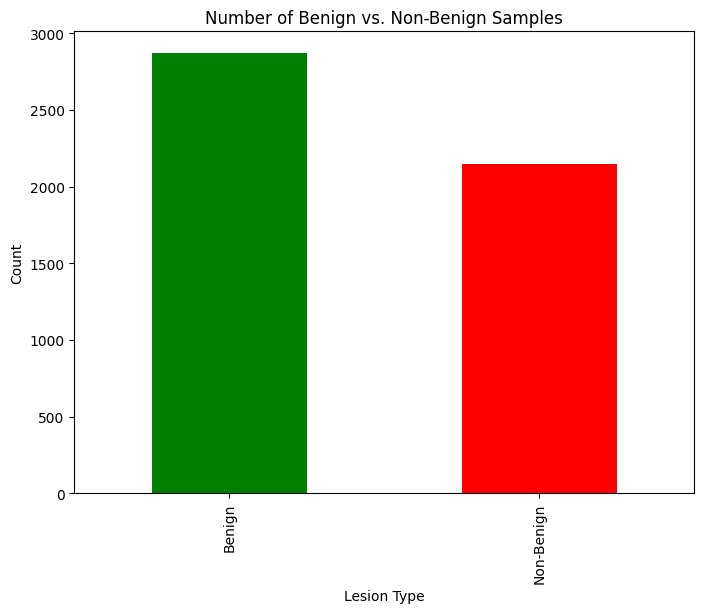

In [ ]:




# Count the number of samples for each class in the dataset
class_counts = tile_df['benign_status'].value_counts()

# Display the counts
print(class_counts)

# Plot the counts
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color=['green', 'red'])
plt.title('Number of Benign vs. Malignant Samples')
plt.xlabel('Lesion Type')
plt.ylabel('Count')
plt.show()


#Saving the Binay model

In [ ]:
# The SavedModel will be saved in a directory named 'skin_lesion_binary_model'
model_binary.save('skin_lesion_binary_model')

# Convert the SavedModel to TensorFlow Lite format
converter_binary = tf.lite.TFLiteConverter.from_saved_model('skin_lesion_binary_model')
tflite_model_binary = converter_binary.convert()

# Save the TensorFlow Lite model to a specific directory
output_path_binary = '/content/skin_lesion_binary_model.tflite'
with open(output_path_binary, 'wb') as f:
    f.write(tflite_model_binary)


#Using ResNet50 alone

In [ ]:
from keras.applications import ResNet50
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Dense
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

input_dims_resnet = (32, 32)
input_shape_resnet = input_dims_resnet + (3,)

# Preprocessing
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean) / x_train_std
x_test = (x_test - x_test_mean) / x_test_std

y_train = to_categorical(y_train_o, num_classes=7)
y_test = to_categorical(y_test_o, num_classes=7)

# Load pre-trained ResNet50 model without the top classification layer
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape_resnet)

# Freeze the pre-trained layers
for layer in base_model_resnet.layers:
    layer.trainable = False

# Create a new model
model_resnet = Sequential()
model_resnet.add(base_model_resnet)
model_resnet.add(GlobalAveragePooling2D())
model_resnet.add(Dense(7, activation='softmax'))

# Compile the ResNet50-based model
model_resnet.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the ResNet50-based model summary
model_resnet.summary()

# Data augmentation for ResNet50
data_augmentation_resnet = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
)

# Train the ResNet50-based model
epochs_resnet = 50
batch_size_resnet = 64

history_resnet = model_resnet.fit(
    data_augmentation_resnet.flow(x_train, y_train, batch_size=batch_size_resnet),
    steps_per_epoch=len(x_train) // batch_size_resnet,
    epochs=epochs_resnet,
    validation_data=(x_test, y_test),
    verbose=1
)



Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 global_average_pooling2d_3  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_14 (Dense)            (None, 7)                 14343     
                                                                 
Total params: 23602055 (90.03 MB)
Trainable params: 14343 (56.03 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________
Epoch 1/50
58/58 [==============================] - 7s 72ms/step - loss: 1.6825 - accuracy: 0.3430 - val_loss: 1.4611 - val_accuracy: 0.4362
Epoch 2/50
58/58 [==============================] - 3s 48ms/step -

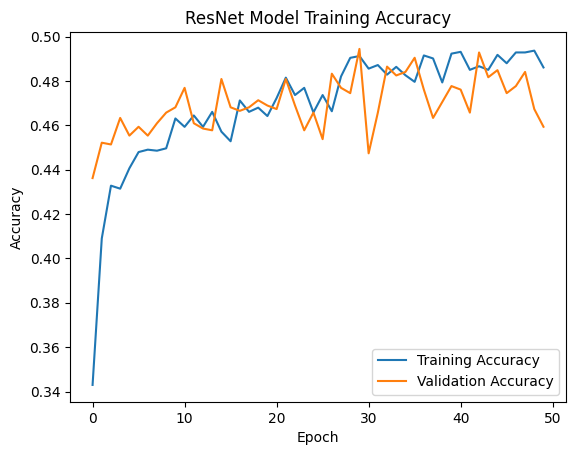

In [ ]:
import matplotlib.pyplot as plt

# Plot the training accuracy
plt.plot(history_resnet.history['accuracy'], label='Training Accuracy')
plt.plot(history_resnet.history['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet Model Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


#Saving the simple ResNet50

In [ ]:
# The SavedModel will be saved in a directory named 'skin_lesion_model_resnet'
model_resnet.save('skin_lesion_model_resnet')

# Convert the SavedModel to TensorFlow Lite format
converter_resnet = tf.lite.TFLiteConverter.from_saved_model('skin_lesion_model_resnet')
tflite_model_resnet = converter_resnet.convert()

# Save the TensorFlow Lite model to a specific directory
output_path_resnet = '/content/skin_lesion_model_resnet.tflite'
with open(output_path_resnet, 'wb') as f:
    f.write(tflite_model_resnet)


#Using ResNet50 + Custom Layers.

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 global_average_pooling2d_4  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_15 (Dense)            (None, 256)               524544    
                                                                 
 dropout_12 (Dropout)        (None, 256)               0         
                                                                 
 dense_16 (Dense)            (None, 7)                 1799      
                                                                 
Total params: 24114055 (91.99 MB)
Trainable params: 526343 (2.01 MB)
Non-trainable params: 23587712 (89.98 MB)
_________

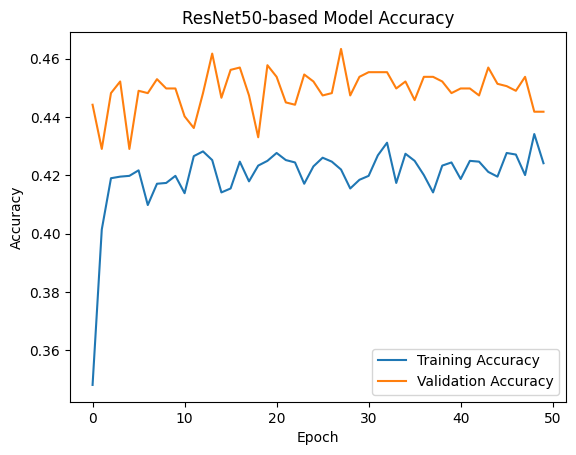

In [ ]:
from keras.applications import ResNet50
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.preprocessing import image
from keras import regularizers
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

input_dims = (32, 32)
input_shape = input_dims + (3,)

# Load in all of the images into memory
tile_df['image'] = tile_df['path'].map(lambda x: np.asarray(Image.open(x).resize(input_dims)))

# Preprocessing
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(tile_df, tile_df.cell_type_idx, test_size=0.25)

# Convert images to numpy arrays
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

# Normalize pixel values
x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)
x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean) / x_train_std
x_test = (x_test - x_test_mean) / x_test_std

# One-hot encode the labels
y_train = to_categorical(y_train_o, num_classes=7)
y_test = to_categorical(y_test_o, num_classes=7)

# Load pre-trained ResNet50 model without the top classification layer
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the pre-trained layers
for layer in base_model_resnet.layers:
    layer.trainable = False

# Create a multi-class classification model on top of ResNet50
model_resnet = Sequential()
model_resnet.add(base_model_resnet)
model_resnet.add(GlobalAveragePooling2D())
model_resnet.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_resnet.add(Dropout(0.5))
model_resnet.add(Dense(7, activation='softmax'))

# Compile the ResNet50-based model
initial_learning_rate_resnet = 0.001
opt_resnet = keras.optimizers.Adam(learning_rate=initial_learning_rate_resnet)
model_resnet.compile(loss='categorical_crossentropy',
                     optimizer=opt_resnet,
                     metrics=['accuracy'])

# Print the ResNet50-based model summary
model_resnet.summary()

# Data augmentation
data_augmentation_resnet = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
)

# Fit the ResNet50-based model
history_resnet = model_resnet.fit(
    data_augmentation_resnet.flow(x_train, y_train, batch_size=batch_size_resnet),
    steps_per_epoch=len(x_train) // batch_size_resnet,
    epochs=epochs_resnet,
    validation_data=(x_test, y_test),
    verbose=1
)

# Plot accuracy
plt.plot(history_resnet.history['accuracy'], label='Training Accuracy')
plt.plot(history_resnet.history['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet50-based Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


#Using VGG16 alone

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 global_average_pooling2d_5  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_17 (Dense)            (None, 7)                 3591      
                                                                 
Total params: 14718279 (56.15 MB)
Trainable params: 3591 (14.03 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________
Epoch 1/50
58/58 [==============================] - 7s 92ms/step - loss: 1.5507 - accuracy: 0.3998 - val_loss: 1.4223 - val_accuracy: 0.4506
E

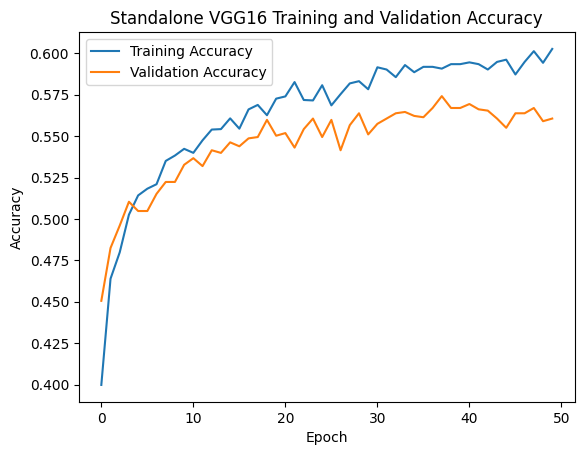

In [ ]:
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Dense
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

input_dims = (32, 32)
input_shape = input_dims + (3,)

# Standalone VGG16
model_vgg16_standalone = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the pre-trained layers
for layer in model_vgg16_standalone.layers:
    layer.trainable = False

# Create a new model
model_standalone = Sequential()

# Add the VGG16 base model
model_standalone.add(model_vgg16_standalone)

# Add Global Average Pooling layer
model_standalone.add(GlobalAveragePooling2D())

# Add Dense layer for classification
model_standalone.add(Dense(7, activation='softmax'))  # 7 prediction classes

# Compile the model
model_standalone.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model_standalone.summary()

# Data augmentation for VGG16
data_augmentation_vgg16 = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
)

# Train the standalone VGG16 model
epochs_standalone = 50
batch_size_standalone = 64

history_standalone = model_standalone.fit(
    data_augmentation_vgg16.flow(x_train, y_train, batch_size=batch_size_standalone),
    steps_per_epoch=len(x_train) // batch_size_standalone,
    epochs=epochs_standalone,
    validation_data=(x_test, y_test),
    verbose=1
)

# Plot accuracy
plt.plot(history_standalone.history['accuracy'], label='Training Accuracy')
plt.plot(history_standalone.history['val_accuracy'], label='Validation Accuracy')
plt.title('Standalone VGG16 Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


#Saving the simple VGG16

In [ ]:
# The SavedModel will be saved in a directory named 'skin_lesion_model_vgg16'
model_standalone.save('skin_lesion_model_vgg16')

# Convert the SavedModel to TensorFlow Lite format
converter_vgg = tf.lite.TFLiteConverter.from_saved_model('skin_lesion_model_vgg16')
tflite_model_vgg = converter_vgg.convert()

# Save the TensorFlow Lite model to a specific directory
output_path_vgg = '/content/skin_lesion_model_vgg16.tflite'
with open(output_path_vgg, 'wb') as f:
    f.write(tflite_model_vgg)


#Using VGG16 + Custom Layers

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 global_average_pooling2d_6  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_18 (Dense)            (None, 256)               131328    
                                                                 
 dropout_13 (Dropout)        (None, 256)               0         
                                                                 
 dense_19 (Dense)            (None, 7)                 1799      
                                                                 
Total params: 14847815 (56.64 MB)
Trainable params: 133127 (520.03 KB)
Non-trainable params: 14714688 (56.13 MB)
______

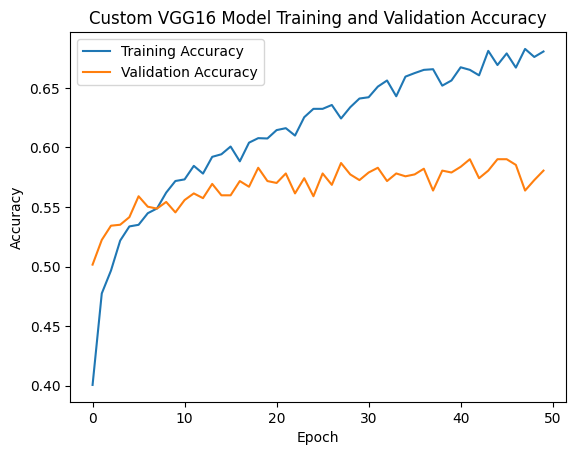

In [ ]:
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

input_dims = (32, 32)
input_shape = input_dims + (3,)

# Standalone VGG16
model_vgg16_standalone = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the pre-trained layers
for layer in model_vgg16_standalone.layers:
    layer.trainable = False

# Create a new model
model_custom_vgg16 = Sequential()

# Add the VGG16 base model
model_custom_vgg16.add(model_vgg16_standalone)

# Add Global Average Pooling layer
model_custom_vgg16.add(GlobalAveragePooling2D())

# Additional Dense layers
model_custom_vgg16.add(Dense(256, activation='relu'))
model_custom_vgg16.add(Dropout(0.5))

# Output layer
model_custom_vgg16.add(Dense(7, activation='softmax'))  # 7 classes

# Compile the model
model_custom_vgg16.compile(optimizer=Adam(learning_rate=0.001),
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])

# Print the model summary
model_custom_vgg16.summary()

# Data augmentation for custom VGG16
data_augmentation_custom_vgg16 = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
)

# Train the custom VGG16 model
epochs_custom_vgg16 = 50
batch_size_custom_vgg16 = 64

history_custom_vgg16 = model_custom_vgg16.fit(
    data_augmentation_custom_vgg16.flow(x_train, y_train, batch_size=batch_size_custom_vgg16),
    steps_per_epoch=len(x_train) // batch_size_custom_vgg16,
    epochs=epochs_custom_vgg16,
    validation_data=(x_test, y_test),
    verbose=1
)

# Plot accuracy
plt.plot(history_custom_vgg16.history['accuracy'], label='Training Accuracy')
plt.plot(history_custom_vgg16.history['val_accuracy'], label='Validation Accuracy')
plt.title('Custom VGG16 Model Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# BASIC MODEL / ResNet50 / VGG16 Comparison

40/40 [==============================] - 0s 4ms/step - loss: 0.7736 - accuracy: 0.7791
Basic Model Test Accuracy: 0.779106855392456
40/40 [==============================] - 1s 14ms/step - loss: 1.4426 - accuracy: 0.4418
ResNet50 Model Test Accuracy: 0.4417862892150879
40/40 [==============================] - 0s 9ms/step - loss: 1.1463 - accuracy: 0.5606
VGG16 Model Test Accuracy: 0.560606062412262
40/40 [==============================] - 0s 7ms/step
Confusion Matrix for Basic Model:


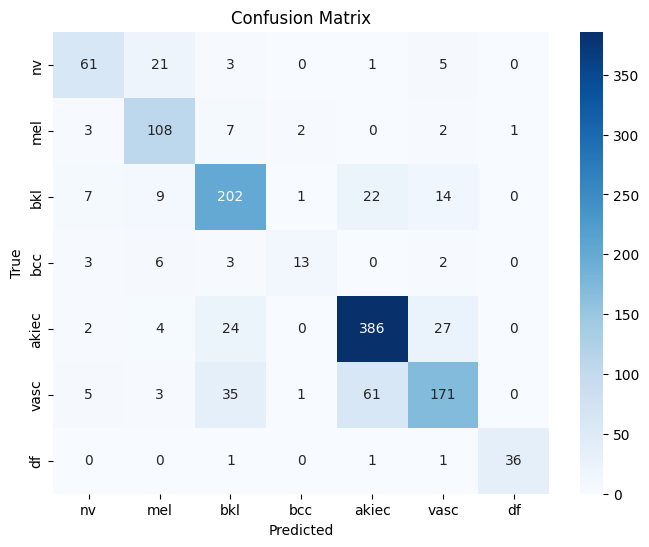


Confusion Matrix for ResNet50 Model:


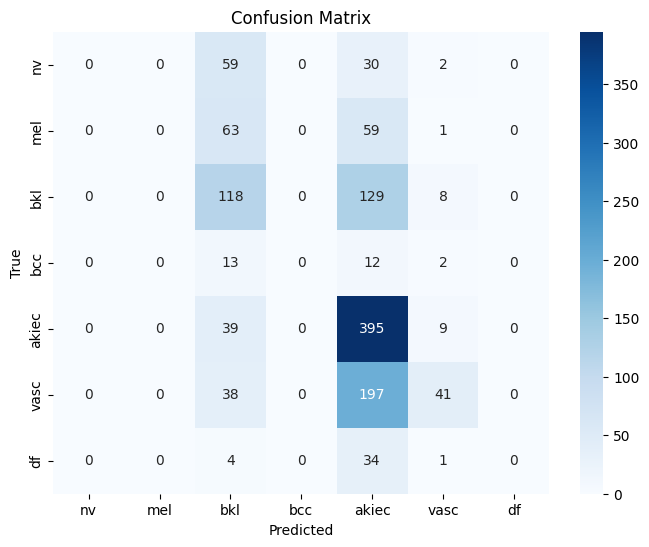


Confusion Matrix for VGG16 Model:


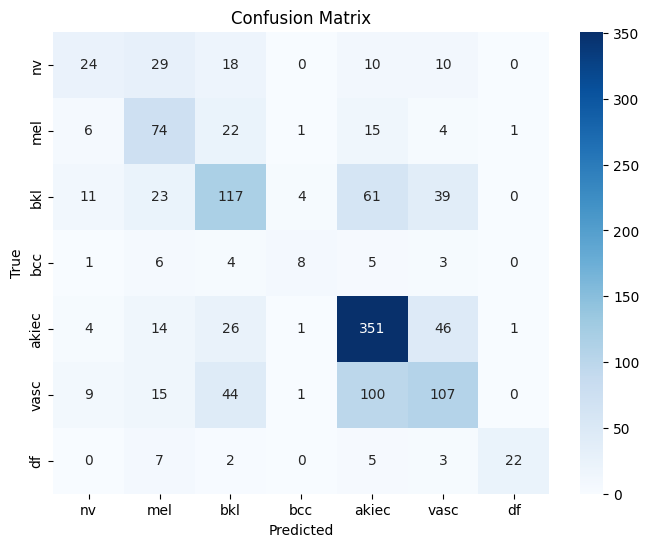

In [ ]:
# Evaluate the basic model
accuracy_basic = model.evaluate(x_test, y_test)[1]
print(f'Basic Model Test Accuracy: {accuracy_basic}')

# Evaluate the ResNet50-based model
accuracy_resnet = model_resnet.evaluate(x_test, y_test)[1]
print(f'ResNet50 Model Test Accuracy: {accuracy_resnet}')

# Evaluate the VGG16-based model
accuracy_vgg16 = model_standalone.evaluate(x_test, y_test)[1]
print(f'VGG16 Model Test Accuracy: {accuracy_vgg16}')

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Get predictions for each model
y_pred_basic = np.argmax(model.predict(x_test), axis=1)
y_pred_resnet = np.argmax(model_resnet.predict(x_test), axis=1)
y_pred_vgg16 = np.argmax(model_standalone.predict(x_test), axis=1)

# Replace class names with skin lesion labels
class_names = ['nv', 'mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df']

# Convert one-hot encoded labels back to single column
y_true_single_column = np.argmax(y_test, axis=1)

# Print model names
print("Confusion Matrix for Basic Model:")
# Plot confusion matrix for the basic model
plot_confusion_matrix(y_true_single_column, y_pred_basic, class_names)

print("\nConfusion Matrix for ResNet50 Model:")
# Plot confusion matrix for the ResNet50 model
plot_confusion_matrix(y_true_single_column, y_pred_resnet, class_names)

print("\nConfusion Matrix for VGG16 Model:")
# Plot confusion matrix for the VGG16 model
plot_confusion_matrix(y_true_single_column, y_pred_vgg16, class_names)





In [ ]:
# Colab2PDF v1.0.4 by Drengskapur (github.com/drengskapur/colab2pdf) (License: GPL-3.0-or-later)
# @title {display-mode:"form"}
# @markdown ⬇️ Download PDF
def colab2pdf():
    ENABLE=True # @param {type:"boolean"}
    if ENABLE:
        !apt-get install librsvg2-bin
        import os, datetime, json, locale, pathlib, urllib, requests, werkzeug, nbformat, google, yaml, warnings
        locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')
        NAME = pathlib.Path(werkzeug.utils.secure_filename(urllib.parse.unquote(requests.get(f"http://{os.environ['COLAB_JUPYTER_IP']}:{os.environ['KMP_TARGET_PORT']}/api/sessions").json()[0]["name"])))
        TEMP = pathlib.Path("/content/pdfs") / f"{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}_{NAME.stem}"; TEMP.mkdir(parents=True, exist_ok=True)
        NB = [cell for cell in nbformat.reads(json.dumps(google.colab._message.blocking_request("get_ipynb", timeout_sec=600)["ipynb"]), as_version=4).cells if "--Colab2PDF" not in cell.source]
        warnings.filterwarnings('ignore', category=nbformat.validator.MissingIDFieldWarning)
        with (TEMP / f"{NAME.stem}.ipynb").open("w", encoding="utf-8") as nb_copy: nbformat.write(nbformat.v4.new_notebook(cells=NB or [nbformat.v4.new_code_cell("#")]), nb_copy)
        if not pathlib.Path("/usr/local/bin/quarto").exists():
            !wget -q "https://quarto.org/download/latest/quarto-linux-amd64.deb" -P {TEMP} && dpkg -i {TEMP}/quarto-linux-amd64.deb > /dev/null && quarto install tinytex --update-path --quiet
        with (TEMP / "config.yml").open("w", encoding="utf-8") as file: yaml.dump({'include-in-header': [{"text": r"\usepackage{fvextra}\DefineVerbatimEnvironment{Highlighting}{Verbatim}{breaksymbolleft={},showspaces=false,showtabs=false,breaklines,breakanywhere,commandchars=\\\{\}}"}],'include-before-body': [{"text": r"\DefineVerbatimEnvironment{verbatim}{Verbatim}{breaksymbolleft={},showspaces=false,showtabs=false,breaklines}"}]}, file)
        !quarto render {TEMP}/{NAME.stem}.ipynb --metadata-file={TEMP}/config.yml --to pdf -M latex-auto-install -M margin-top=1in -M margin-bottom=1in -M margin-left=1in -M margin-right=1in --quiet
        google.colab.files.download(str(TEMP / f"{NAME.stem}.pdf"))
colab2pdf()

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
librsvg2-bin is already the newest version (2.52.5+dfsg-3ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>